# Conectando ao drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import shutil

pasta_origem = '/content/drive/MyDrive/Trabalho IA'
pasta_destino_treino = '/content/drive/MyDrive/Trabalho IA/Treino'
pasta_destino_teste = '/content/drive/MyDrive/Trabalho IA/Teste'
pasta_destino_validacao = '/content/drive/MyDrive/Trabalho IA/Validacao'

In [ ]:
os.makedirs(pasta_destino_treino, exist_ok=True)
os.makedirs(pasta_destino_teste, exist_ok=True)
os.makedirs(pasta_destino_validacao, exist_ok=True)

In [ ]:
proporcao_treino = 0.7
proporcao_teste = 0.15
proporcao_validacao = 0.15

In [ ]:
classes = os.listdir(pasta_origem)

for classe in classes:
    if classe == 'Treino' or classe == 'Teste' or classe == 'Validacao':
      continue
    pasta_classe_origem = os.path.join(pasta_origem, classe)
    pasta_classe_treino = os.path.join(pasta_destino_treino, classe)
    pasta_classe_teste = os.path.join(pasta_destino_teste, classe)
    pasta_classe_validacao = os.path.join(pasta_destino_validacao, classe)

    os.makedirs(pasta_classe_treino, exist_ok=True)
    os.makedirs(pasta_classe_teste, exist_ok=True)
    os.makedirs(pasta_classe_validacao, exist_ok=True)

    imagens = os.listdir(pasta_classe_origem)
    total_imagens = len(imagens)

    indice_treino = int(total_imagens * proporcao_treino)
    indice_teste = int(total_imagens * (proporcao_treino + proporcao_teste))

    for i, imagem in enumerate(imagens):
        caminho_origem = os.path.join(pasta_classe_origem, imagem)

        if i < indice_treino:
            caminho_destino = os.path.join(pasta_classe_treino, imagem)
        elif i < indice_teste:
            caminho_destino = os.path.join(pasta_classe_teste, imagem)
        else:
            caminho_destino = os.path.join(pasta_classe_validacao, imagem)

        shutil.copy(caminho_origem, caminho_destino)

# Rede Neural

In [ ]:
import torch
import torch.nn as nn

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # Camadas convolucionais
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
        self.conv7 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
        self.conv8 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)

        # Camadas lineares
        self.fc1 = nn.Linear(512 * 14 * 14, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 100)  # 100 classes de saída

        # Camada de pooling
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Função de ativação
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.pool(x)

        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = self.pool(x)

        x = self.relu(self.conv5(x))
        x = self.relu(self.conv6(x))
        x = self.pool(x)

        x = self.relu(self.conv7(x))
        x = self.relu(self.conv8(x))
        x = self.pool(x)

        x = x.view(x.size(0), -1)  # Achata os dados

        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)

        return x

In [ ]:
!pip install gradient-descent-the-ultimate-optimizer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from gradient_descent_the_ultimate_optimizer import gdtuo

In [ ]:
modelo = CNN()

# Treinamento com CIFAR100

In [ ]:
BATCH_SIZE = 32
EPOCHS = 5
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
modelo.to(DEVICE)

transformacao = transforms.Compose([
    transforms.Resize((224, 224)),  # Redimensiona as imagens para o tamanho desejado
    transforms.ToTensor(),  # Converte as imagens para tensores do PyTorch
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normaliza os valores dos pixels entre -1 e 1
])

cifar_train = torchvision.datasets.CIFAR100('./data', train=True, download=True, transform=transformacao)
cifar_test = torchvision.datasets.CIFAR100('./data', train=False, download=True, transform=transformacao)
dl_train = torch.utils.data.DataLoader(cifar_train, batch_size=BATCH_SIZE, shuffle=True)
dl_test = torch.utils.data.DataLoader(cifar_test, batch_size=BATCH_SIZE, shuffle=False)

lloss = nn.CrossEntropyLoss()
optim = gdtuo.Adam(optimizer=gdtuo.SGD(1e-5))
mw = gdtuo.ModuleWrapper(modelo, optimizer=optim)
mw.initialize()

for i in range(1, EPOCHS+1):
    running_loss = 0.0
    for j, (features_, labels_) in enumerate(dl_train):
        mw.begin() # call this before each step, enables gradient tracking on desired params
        features, labels = features_.to(DEVICE), labels_.to(DEVICE)
        pred = mw.forward(features)
        loss = lloss(pred, labels)
        mw.zero_grad()
        loss.backward() # important! use create_graph=True
        mw.step()
        running_loss += loss.item() * features_.size(0)
    train_loss = running_loss / len(dl_train.dataset)
    print("EPOCH: {}, TRAIN LOSS: {}".format(i, train_loss))


100%|██████████| 169001437/169001437 [00:02<00:00, 76698832.82it/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified
EPOCH: 1, TRAIN LOSS: 4.606215459442138
EPOCH: 2, TRAIN LOSS: 4.605942235107422
EPOCH: 3, TRAIN LOSS: 4.605905676574707
EPOCH: 4, TRAIN LOSS: 4.605875799560547
EPOCH: 5, TRAIN LOSS: 4.605883851928711


In [ ]:
torch.save(modelo.state_dict(), 'modelo_weights.pth')

# Transform

In [ ]:
transformacao = transforms.Compose([
    transforms.Resize((224, 224)),  # Redimensiona as imagens para o tamanho desejado
    transforms.ToTensor(),  # Converte as imagens para tensores do PyTorch
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normaliza os valores dos pixels entre -1 e 1
])

conjunto_treino = torchvision.datasets.ImageFolder(root=pasta_destino_treino, transform=transformacao)
conjunto_teste = torchvision.datasets.ImageFolder(root=pasta_destino_teste, transform=transformacao)
conjunto_validacao = torchvision.datasets.ImageFolder(root=pasta_destino_validacao, transform=transformacao)

tamanho_lote = 64

dataloader_treino = torch.utils.data.DataLoader(conjunto_treino, batch_size=tamanho_lote, shuffle=True)
dataloader_teste = torch.utils.data.DataLoader(conjunto_teste, batch_size=tamanho_lote, shuffle=False)
dataloader_validacao = torch.utils.data.DataLoader(conjunto_validacao, batch_size=tamanho_lote, shuffle=False)

print(conjunto_treino)
print(conjunto_teste)
print(conjunto_validacao)

Dataset ImageFolder
    Number of datapoints: 435
    Root location: /content/drive/MyDrive/Trabalho IA/Treino
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )
Dataset ImageFolder
    Number of datapoints: 93
    Root location: /content/drive/MyDrive/Trabalho IA/Teste
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )
Dataset ImageFolder
    Number of datapoints: 96
    Root location: /content/drive/MyDrive/Trabalho IA/Validacao
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
               Norm

# Gráfico para verificar loss de treino e verificação

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

def treinar(modelo, treinador, validador, epocas):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    modelo = modelo.to(device)

    print(device)

    criterio = nn.CrossEntropyLoss()
    otimizador = optim.Adam(modelo.parameters(), lr=0.001)

    perdas_treino = []
    perdas_validacao = []

    for epoca in range(epocas):
        perda_treino = 0.0
        perda_validacao = 0.0

        # Treinamento do modelo
        modelo.train()
        for imagens, rotulos in treinador:
            imagens, rotulos = imagens.to(device), rotulos.to(device)
            otimizador.zero_grad()

            saidas = modelo(imagens)
            perda = criterio(saidas, rotulos)
            perda.backward()
            otimizador.step()

            perda_treino += perda.item() * imagens.size(0)

        # Validação do modelo
        modelo.eval()
        with torch.no_grad():
            for imagens, rotulos in validador:
                imagens, rotulos = imagens.to(device), rotulos.to(device)
                saidas = modelo(imagens)
                perda = criterio(saidas, rotulos)

                perda_validacao += perda.item() * imagens.size(0)

        perda_treino = perda_treino / len(treinador.dataset)
        perda_validacao = perda_validacao / len(validador.dataset)

        perdas_treino.append(perda_treino)
        perdas_validacao.append(perda_validacao)

        print(f'Época {epoca+1}/{epocas} - Loss de Treino: {perda_treino:.4f} - Perda de Validação: {perda_validacao:.4f}')

    # Plotando as curvas de perda
    plt.plot(range(1, epocas+1), perdas_treino, label='Loss de Treino')
    plt.plot(range(1, epocas+1), perdas_validacao, label='Loss de Validação')
    plt.xlabel('Épocas')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [ ]:
modelo = CNN()

cuda
Época 1/10 - Loss de Treino: 3.2655 - Perda de Validação: 2.1761
Época 2/10 - Loss de Treino: 1.9296 - Perda de Validação: 1.7428
Época 3/10 - Loss de Treino: 1.6731 - Perda de Validação: 1.6588
Época 4/10 - Loss de Treino: 1.6430 - Perda de Validação: 1.6278
Época 5/10 - Loss de Treino: 1.6481 - Perda de Validação: 1.6212
Época 6/10 - Loss de Treino: 1.6322 - Perda de Validação: 1.6102
Época 7/10 - Loss de Treino: 1.6225 - Perda de Validação: 1.6130
Época 8/10 - Loss de Treino: 1.6170 - Perda de Validação: 1.6062
Época 9/10 - Loss de Treino: 1.6312 - Perda de Validação: 1.6114
Época 10/10 - Loss de Treino: 1.6385 - Perda de Validação: 1.6253


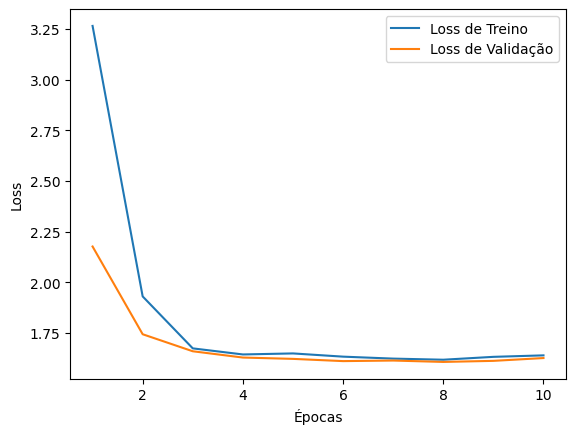

In [ ]:
treinar(modelo, dataloader_treino, dataloader_validacao, 10)

# Matriz de Confusão

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def testar(modelo, testeloader):
    dispositivo = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    modelo = modelo.to(dispositivo)

    modelo.eval()
    predicoes = []
    rotulos = []

    with torch.no_grad():
        for imagens, targets in testeloader:
            imagens = imagens.to(dispositivo)
            targets = targets.to(dispositivo)

            saidas = modelo(imagens)
            _, pred = torch.max(saidas, 1)

            predicoes.extend(pred.cpu().tolist())
            rotulos.extend(targets.cpu().tolist())

    matriz_confusao = confusion_matrix(rotulos, predicoes)

    # Plotando a matriz de confusão
    plt.figure(figsize=(10, 10))
    sns.heatmap(matriz_confusao, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Rótulo Predito')
    plt.ylabel('Rótulo Verdadeiro')
    plt.title('Matriz de Confusão')
    plt.show()

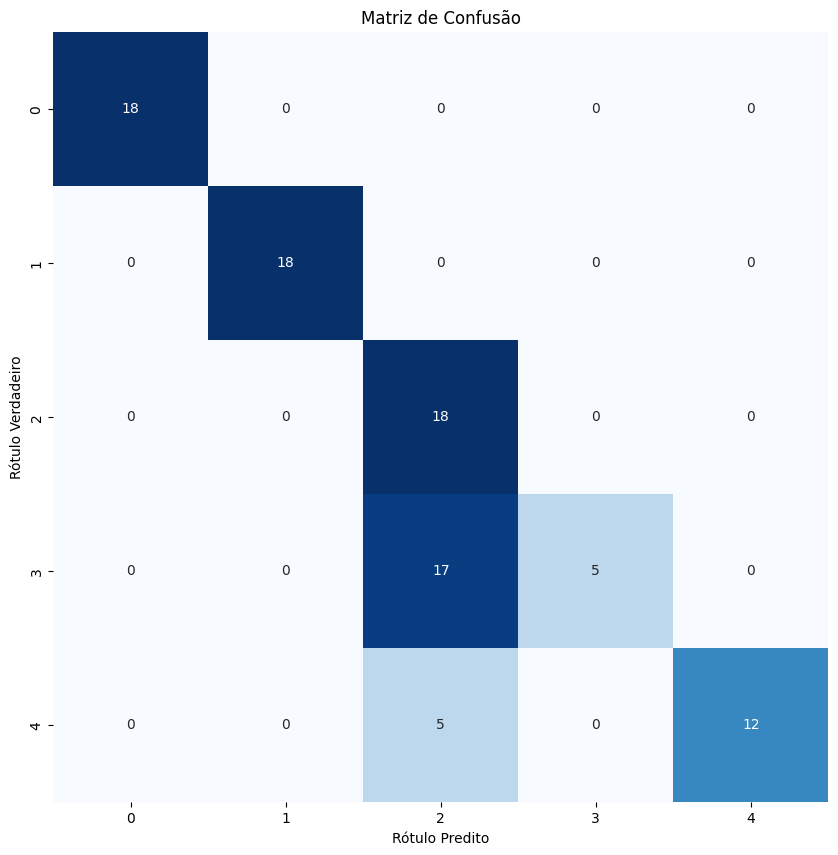

In [ ]:
testar(modelo, dataloader_teste)

# Métricas

In [ ]:
import torch
import numpy as np
from sklearn.metrics import classification_report

def calcular_metricas(modelo, testeloader):
    dispositivo = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    modelo = modelo.to(dispositivo)

    modelo.eval()
    predicoes = []
    rotulos = []

    with torch.no_grad():
        for imagens, targets in testeloader:
            imagens = imagens.to(dispositivo)
            targets = targets.to(dispositivo)

            saidas = modelo(imagens)
            _, pred = torch.max(saidas, 1)

            predicoes.extend(pred.cpu().tolist())
            rotulos.extend(targets.cpu().tolist())

    relatorio = classification_report(rotulos, predicoes)
    print(relatorio)

In [ ]:
calcular_metricas(modelo, dataloader_teste)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        18
           1       1.00      1.00      1.00        18
           2       0.45      1.00      0.62        18
           3       1.00      0.23      0.37        22
           4       1.00      0.71      0.83        17

    accuracy                           0.76        93
   macro avg       0.89      0.79      0.76        93
weighted avg       0.89      0.76      0.75        93

